# Linear Regression

The data set consists of the sales of a product in 200 different markets, along with advertising budgets (in $1,000) for the product in each of those markets for three different media: TV, radio,and newspaper.

### Goal

To develop an accurate model that can be used to predict sales on the basis of the three media budgets.

### Initial Setups

In [52]:
#Required libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [53]:
#Read data from csv file
data = pd.read_csv('Data\cs_04.csv')
data.head()

,no,tv,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [54]:
data.shape

(200, 5)

# Data Understanding - Phase 1

#### 1: Understand data collection process

Data ??

Note: data collection process is based on ??

#### 2: Document data set description (meta data)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   no         200 non-null    int64  
 1   tv         200 non-null    float64
 2   radio      200 non-null    float64
 3   newspaper  200 non-null    float64
 4   sales      200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB



0 no        : number of the market

1 tv        : advertising budgets (in 1,000) for TV (numeric)

2 radio     : advertising budgets (in 1,000) for radio (numeric)

3 newspaper : advertising budgets (in 1,000) for newspaper (numeric)

4 sales     : sales of a product (in 1,000) (numeric)

#### 3: Check for missing values

In [56]:
np.sum(data.isnull())

no           0
tv           0
radio        0
newspaper    0
sales        0
dtype: int64

#### 4: Univariate data analysis

In [57]:
# Check if all numbers are unique
print(data['no'].nunique())
print(data.shape[0])

200
200


In [58]:
# Chech if there is duplicate rows
np.sum(data.duplicated())

0

In [59]:
#Assumption: no data drift
#data drift : occurs when the distribution of the input data changes over time.
#such as inflation in sales

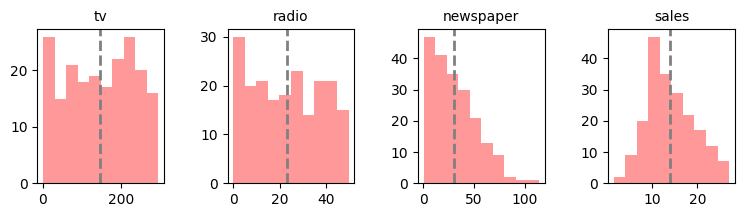

In [60]:
# Histogram of numeric variables
from scipy import stats

var_ind = list(range(1, 5))
plt.figure(figsize = (9, 2))
plt.subplots_adjust(hspace = .5, wspace = .5)

for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.hist(x = data.iloc[: , var_ind[i - 1]], alpha = .4, color = 'red') #, density = True)
    
    plt.axvline(data.iloc[: , var_ind[i - 1]].mean(), color = 'gray', linewidth = 2, linestyle = '--')
    
    #density = stats.gaussian_kde(data.iloc[: , var_ind[i - 1]])
    #xp = np.linspace(data.iloc[: , var_ind[i - 1]].min(), data.iloc[: , var_ind[i - 1]].max(), 100)
    #yp = density.pdf(xp)
    #plt.plot(xp, yp, color = 'gray', linewidth = 2)
    
    plt.title(data.columns[var_ind[i - 1]], fontsize = 10)


In [61]:
#Summary statistics of numeric variables
data.iloc[:, 1 : 6].describe()

,tv,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## Data Preparation

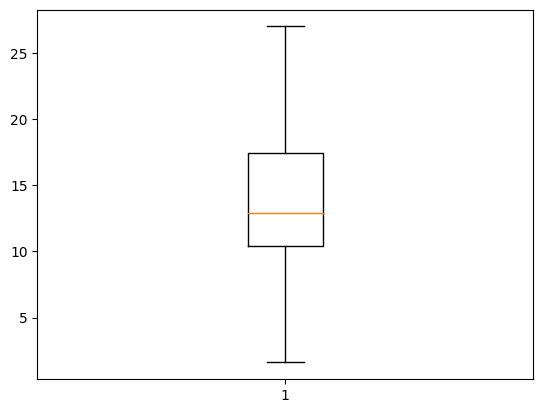

In [62]:
# Check for outliers
plt.boxplot(data['sales'])
plt.show()

## Data Understanding - Phase 2

#### 5: Bivariate data analysis

In [63]:
#Correlation analysis
round(data.iloc[:, 1:5].corr(method = 'pearson'), 2)

,tv,radio,newspaper,sales
tv,1.00,0.05,0.06,0.78
radio,0.05,1.00,0.35,0.58
newspaper,0.06,0.35,1.00,0.23
sales,0.78,0.58,0.23,1.00


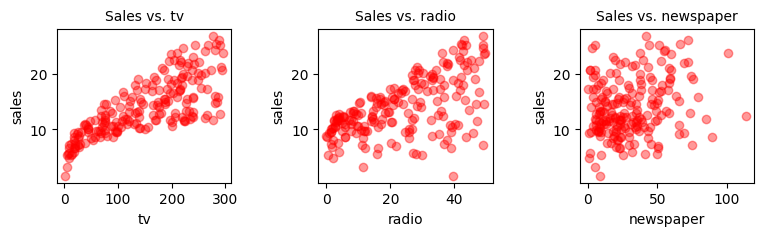

In [64]:
#Scatter plot
var_ind = list(range(1, 4))
plt.figure(figsize = (9, 2))
plt.subplots_adjust(hspace = .5, wspace = .5)

for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.scatter(x = data.iloc[: , var_ind[i - 1]], y = data['sales'], alpha = .4, color = 'red')
    plt.title('Sales vs. ' + data.columns[var_ind[i - 1]], fontsize = 10)
    plt.xlabel(data.columns[var_ind[i - 1]])
    plt.ylabel('sales')

## Build Linear Regression Model

In [65]:
#Split data into test and train
train, test = train_test_split(data, test_size = .2, random_state = 123)
print(train.shape)
print(test.shape)

(160, 5)
(40, 5)


In [66]:
#Define feature matrix 
x_train = train['tv']
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv
24,1.0,62.3
150,1.0,280.7
114,1.0,78.2
33,1.0,265.6
23,1.0,228.3


In [67]:
#Define response matrix
y_train = train['sales']
y_train.head()

24      9.7
150    16.1
114    14.6
33     17.4
23     15.5
Name: sales, dtype: float64

In [68]:
#Linear regression - mpdel 1
model_1 = sm.OLS(y_train, x_train).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     229.2
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.44e-32
Time:                        05:24:51   Log-Likelihood:                -416.24
No. Observations:                 160   AIC:                             836.5
Df Residuals:                     158   BIC:                             842.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1815      0.525     13.673      0.000       6.144       8.219
tv             0.0459      0.003     15.140      0.000       0.040       0.052
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                1.130
Skew:                          -0.022   Prob(JB):                        0.568
Kurtosis:                       2.591   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
#Function to plot histogram of residuals
def hist_residuals(model, bins = 50):
    #Calculate density
    from scipy import stats
    density = stats.gaussian_kde(model.resid)
    xp = np.linspace(model.resid.min(), model.resid.max(), 100)
    yp = density.pdf(xp)

    #Histogram
    plt.hist(model.resid, bins = bins, 
             color = 'red', alpha = .4, density = True)
    plt.axvline(model.resid.mean(), color = 'gray', 
                linewidth = 2, linestyle = '--', label = "Average")
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.plot(xp, yp, color = 'gray', linewidth = 2)
    plt.legend()
    
    return plt.show()    

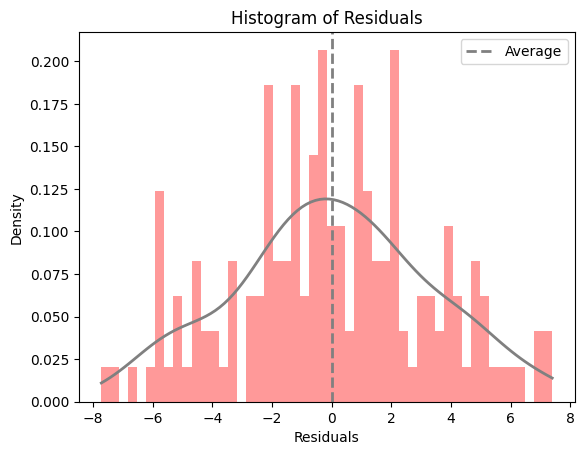

In [70]:
#Histogram of residuals - model 1
hist_residuals(model_1)

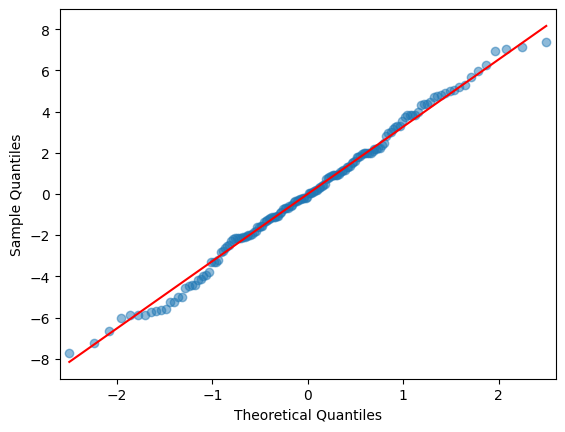

In [71]:
#QQ-plot - model 1
sm.qqplot(model_1.resid, line = 's', alpha = .5)
plt.show()

In [72]:
#Function to plot residuals vs. fitted values
def residuals_fittedvalues_plot(model):
    #Implement Lowess algorithm
    lowess_res = sm.nonparametric.lowess(model.resid, model.fittedvalues)

    #Scatter plot: residuals vs. fitted values
    plt.scatter(x = model.fittedvalues, y = model.resid, 
                color = 'red', alpha = .4, label = 'data')
    plt.title('Residuals vs. Fitted values')
    plt.xlabel('Fitted Values', fontsize = 12)
    plt.ylabel('Residuals', fontsize = 12)
    plt.grid()

    #Add LOWESS line
    plt.plot(lowess_res[:, 0], lowess_res[:, 1], 'gray', 
             alpha = .8, linewidth = 2, label = 'LOWESS')
    plt.legend()
    
    #Top three observations with greates absolute value of the residual
    top3 = abs(model.resid).sort_values(ascending = False)[:3]
    for i in top3.index:
        plt.annotate(i, xy = (model.fittedvalues[i], model.resid[i]), color = 'blue')
    
    return plt.show()

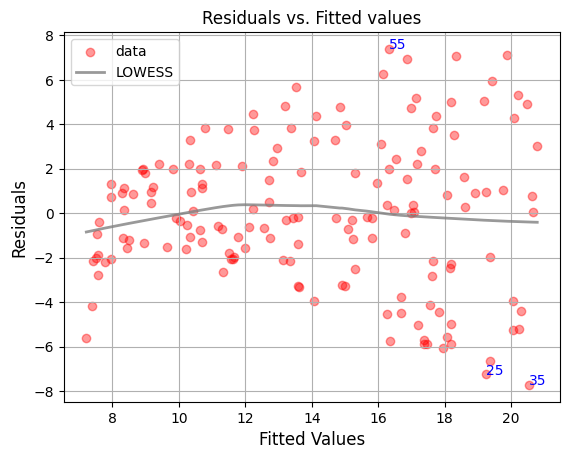

In [73]:
#Scatter plot of residuals vs. fitted values - model 1
residuals_fittedvalues_plot(model_1)

In [74]:
print('Increasing the TV advertising budget by $1,000 will result in a sales increase of ${p_sale}.'
     .format(p_sale = round(.047 * 1 + 7.0766, 2))) # model_tv.predict([1,1])

Increasing the TV advertising budget by $1,000 will result in a sales increase of $7.12.


In [75]:
#Box-Cox transformation
from sklearn.preprocessing import PowerTransformer
boxcox = PowerTransformer(method = 'box-cox')
boxcox.fit(y_train.values.reshape(-1, 1))
boxcox.lambdas_

array([0.65457649])

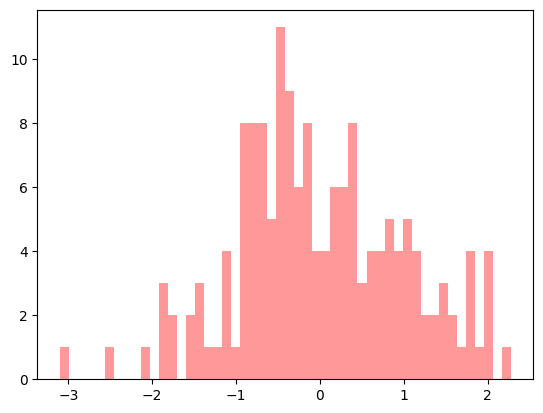

In [76]:
trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))
plt.hist(trans_y_train, color = 'red', alpha = .4, bins = 50)
plt.show()

In [77]:
#Linear regression - mpdel 2
model_2 = sm.OLS(trans_y_train, x_train).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     244.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           6.16e-34
Time:                        05:24:51   Log-Likelihood:                -152.14
No. Observations:                 160   AIC:                             308.3
Df Residuals:                     158   BIC:                             314.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3716      0.101    -13.605      0.000      -1.571      -1.172
tv             0.0091      0.001     15.650      0.000       0.008       0.010
==============================================================================
Omnibus:                        2.952   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                2.698
Skew:                          -0.237   Prob(JB):                        0.259
Kurtosis:                       2.576   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

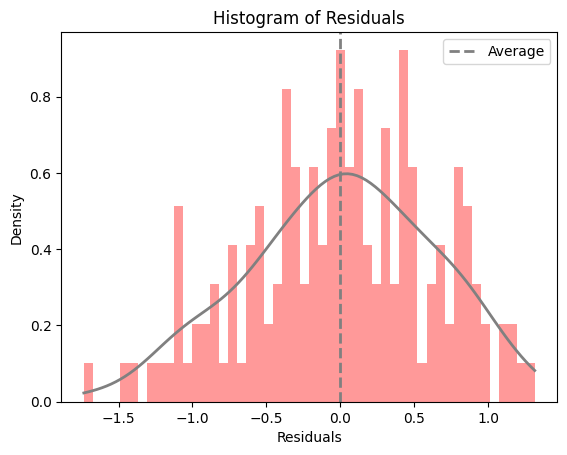

In [78]:
#Histogram of residuals - model 2
hist_residuals(model_2)

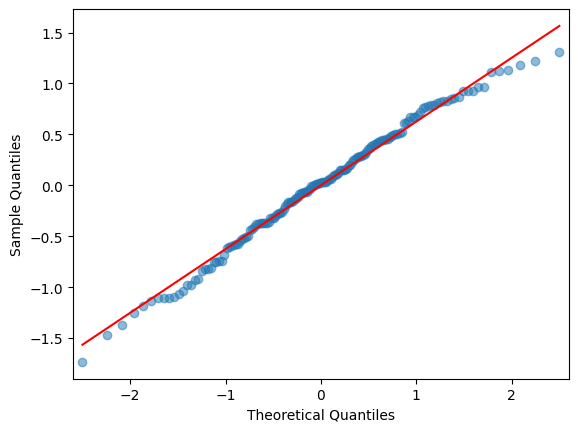

In [79]:
#QQ-plot - model 2
sm.qqplot(model_2.resid, line = 's', alpha = .5)
plt.show()

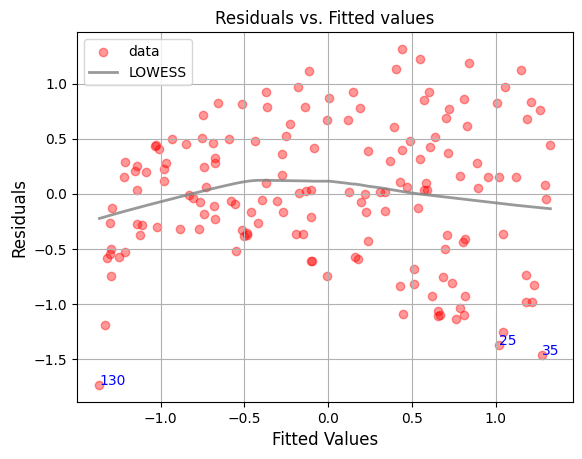

In [80]:
#Scatter plot of residuals vs. fitted values - model 2
residuals_fittedvalues_plot(model_2)

In [81]:
#Define feature matrix 
x_train = train.iloc[:, 1:4]
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv,radio,newspaper
24,1.0,62.3,12.6,18.3
150,1.0,280.7,13.9,37.0
114,1.0,78.2,46.8,34.5
33,1.0,265.6,20.0,0.3
23,1.0,228.3,16.9,26.2


In [82]:
#Define response matrix
y_train = train['sales']
y_train.head()

24      9.7
150    16.1
114    14.6
33     17.4
23     15.5
Name: sales, dtype: float64

In [83]:
#Linear regression - model 3
model_3 = sm.OLS(y_train, x_train).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     409.8
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           9.89e-74
Time:                        05:24:52   Log-Likelihood:                -313.24
No. Observations:                 160   AIC:                             634.5
Df Residuals:                     156   BIC:                             646.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9242      0.365      8.018      0.000       2.204       3.645
tv             0.0456      0.002     28.437      0.000       0.042       0.049
radio          0.1865      0.010     18.700      0.000       0.167       0.206
newspaper     -0.0006      0.007     -0.094      0.925      -0.014       0.013
==============================================================================
Omnibus:                       50.642   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.512
Skew:                          -1.335   Prob(JB):                     1.51e-27
Kurtosis:                       6.376   Cond. No.                         469.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

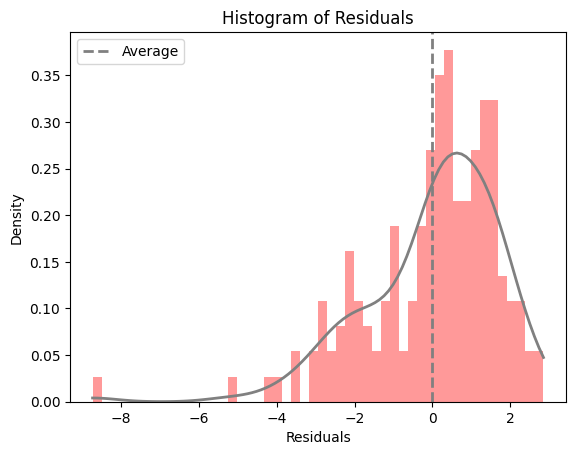

In [84]:
#Histogram of residuals - model 3
hist_residuals(model_3)

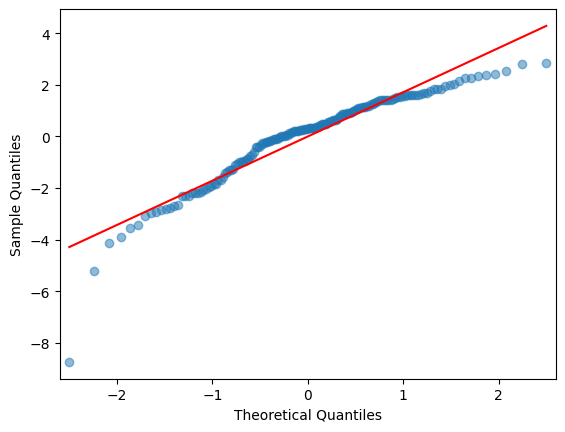

In [85]:
#QQ-plot - model 3
sm.qqplot(model_3.resid, line = 's', alpha = .5)
plt.show()

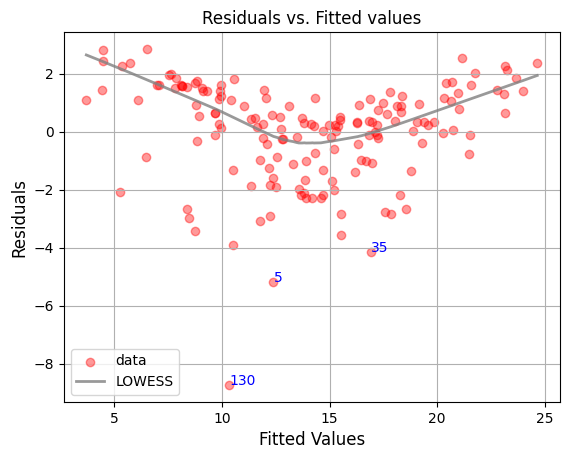

In [86]:
#Scatter plot of residuals vs. fitted values - model 3
residuals_fittedvalues_plot(model_3)

In [87]:
#Function to check Cook's distance
def influencer_detector(model, thershold = 1):
    
    #create instance of influence
    influence = model.get_influence()

    #Obtain Cook's distance for each observation
    cooks = influence.cooks_distance

    #Check observations w/ Cook's distance greater than thershold
    return np.where(cooks[0] > 1)

In [88]:
#Check Cook's ditance - model 3
influencer_detector(model_3)

(array([], dtype=int64),)

In [89]:
#Remove non-significant variables from regression model
x_train.drop(columns = ['newspaper'], inplace = True)

In [90]:
#Linear regression - model 4
model_4 = sm.OLS(y_train, x_train).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     618.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.53e-75
Time:                        05:24:53   Log-Likelihood:                -313.24
No. Observations:                 160   AIC:                             632.5
Df Residuals:                     157   BIC:                             641.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9142      0.348      8.383      0.000       2.228       3.601
tv             0.0456      0.002     28.534      0.000       0.042       0.049
radio          0.1862      0.009     20.295      0.000       0.168       0.204
==============================================================================
Omnibus:                       50.430   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.084
Skew:                          -1.333   Prob(JB):                     3.09e-27
Kurtosis:                       6.348   Cond. No.                         443.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

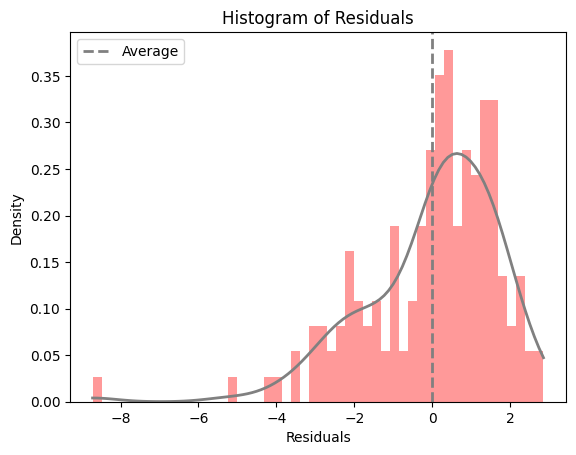

In [91]:
#Histogram of residuals - model 4
hist_residuals(model_4)

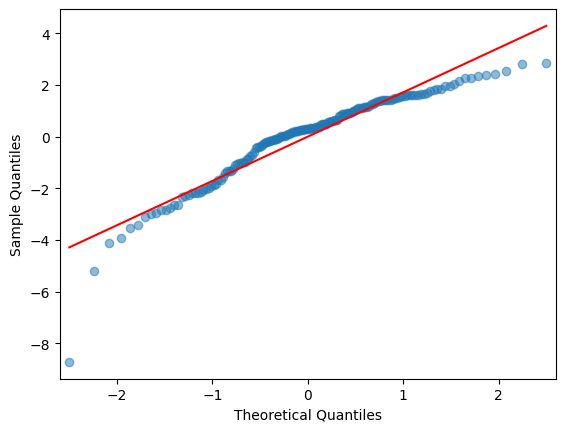

In [92]:
#QQ-plot - model 4
sm.qqplot(model_4.resid, line = 's', alpha = .5)
plt.show()

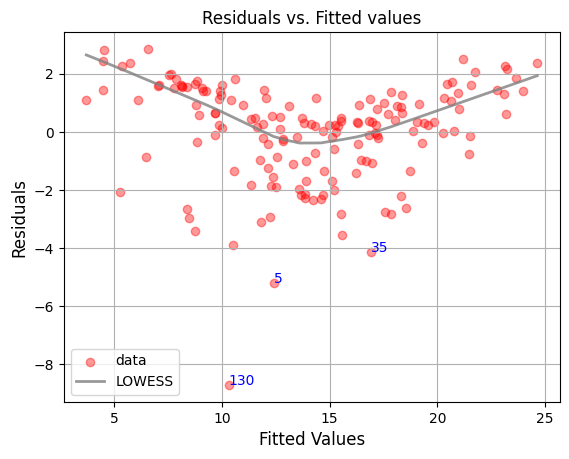

In [93]:
#Scatter plot of residuals vs. fitted values - model 4
residuals_fittedvalues_plot(model_4)

In [94]:
#Check Cook's ditance - model 4
influencer_detector(model_4)

(array([], dtype=int64),)

In [95]:
#Box-Cox transformation
boxcox = PowerTransformer(method = 'box-cox')
boxcox.fit(y_train.values.reshape(-1, 1))
boxcox.lambdas_

array([0.65457649])

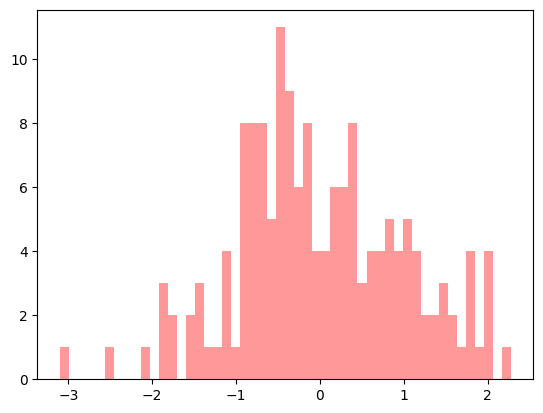

In [96]:
trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))
plt.hist(trans_y_train, color = 'red', alpha = .4, bins = 50)
plt.show()

In [97]:
#Linear regression - model 5
model_5 = sm.OLS(trans_y_train, x_train).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     543.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.70e-71
Time:                        05:24:53   Log-Likelihood:                -61.436
No. Observations:                 160   AIC:                             128.9
Df Residuals:                     157   BIC:                             138.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1643      0.072    -30.040      0.000      -2.307      -2.022
tv             0.0090      0.000     27.325      0.000       0.008       0.010
radio          0.0346      0.002     18.190      0.000       0.031       0.038
==============================================================================
Omnibus:                      104.763   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.280
Skew:                          -2.317   Prob(JB):                    6.21e-180
Kurtosis:                      13.116   Cond. No.                         443.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

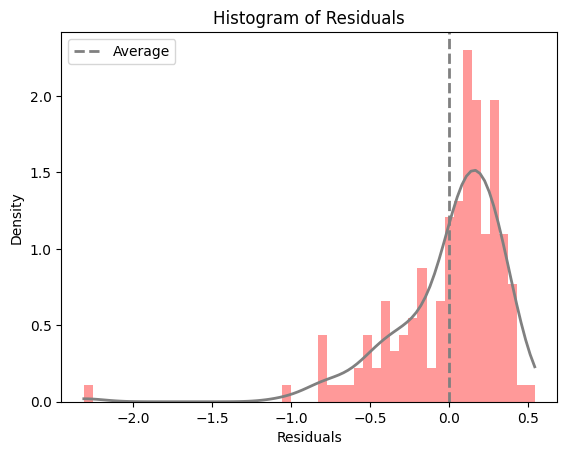

In [98]:
#Histogram of residuals - model 5
hist_residuals(model_5)

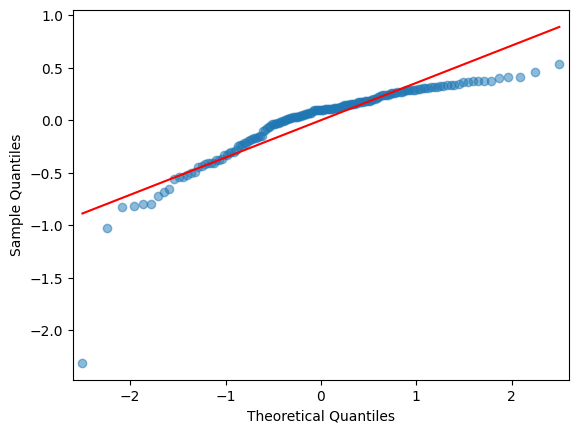

In [99]:
#QQ-plot - model 5
sm.qqplot(model_5.resid, line = 's', alpha = .5)
plt.show()

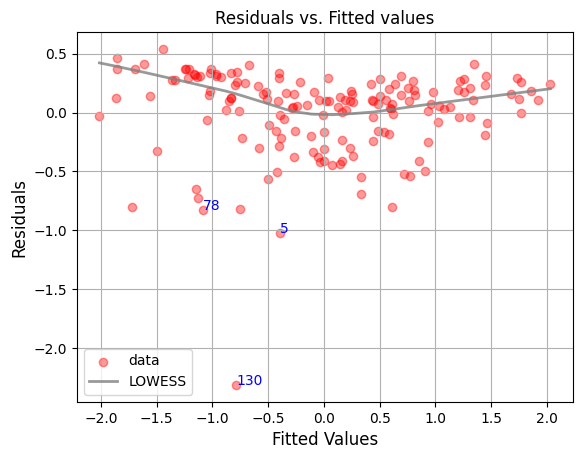

In [100]:
#Scatter plot of residuals vs. fitted values - model 5
residuals_fittedvalues_plot(model_5)

In [101]:
#Function to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    #Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return(vif)

In [102]:
#Check multicollinearity for numeric variables
calc_vif(x_train)
#Note: If VIF > 10 then multicollinearity is high

,variables,VIF
0,const,6.457568
1,tv,1.000091
2,radio,1.000091


## Interaction Effect

In [103]:
#Create new feature based on tv and radio budget
train['int_var'] = train['tv']*train['radio']
train.reindex(columns = ['tv', 'radio', 'newspaper', 'int_var', 'sales'])
train.head()

,no,tv,radio,newspaper,sales,int_var
24,25,62.3,12.6,18.3,9.7,784.98
150,151,280.7,13.9,37.0,16.1,3901.73
114,115,78.2,46.8,34.5,14.6,3659.76
33,34,265.6,20.0,0.3,17.4,5312.00
23,24,228.3,16.9,26.2,15.5,3858.27


In [104]:
#Define feature matrix
x_train = train.iloc[:, [1, 2, 5]]
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv,radio,int_var
24,1.0,62.3,12.6,784.98
150,1.0,280.7,13.9,3901.73
114,1.0,78.2,46.8,3659.76
33,1.0,265.6,20.0,5312.00
23,1.0,228.3,16.9,3858.27


In [105]:
#Linear regression - model 6
model_6 = sm.OLS(trans_y_train, x_train).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     685.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.35e-89
Time:                        05:24:54   Log-Likelihood:                -14.824
No. Observations:                 160   AIC:                             37.65
Df Residuals:                     156   BIC:                             49.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5030      0.080    -18.699      0.000      -1.662      -1.344
tv             0.0045      0.000      9.459      0.000       0.004       0.005
radio          0.0078      0.003      2.777      0.006       0.002       0.013
int_var        0.0002   1.65e-05     11.107      0.000       0.000       0.000
==============================================================================
Omnibus:                      142.110   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2262.392
Skew:                          -3.176   Prob(JB):                         0.00
Kurtosis:                      20.292   Cond. No.                     1.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

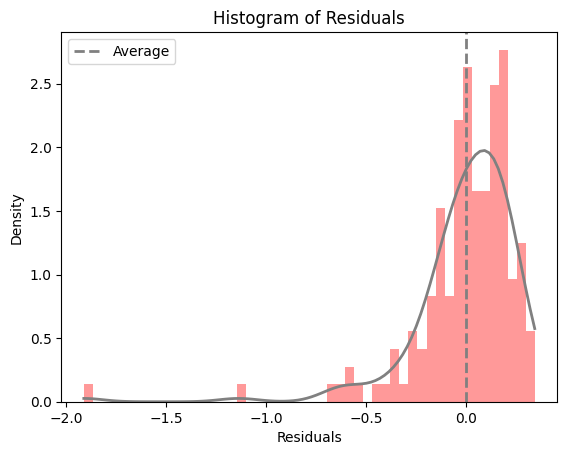

In [106]:
#Histogram of residuals model 6
hist_residuals(model_6)

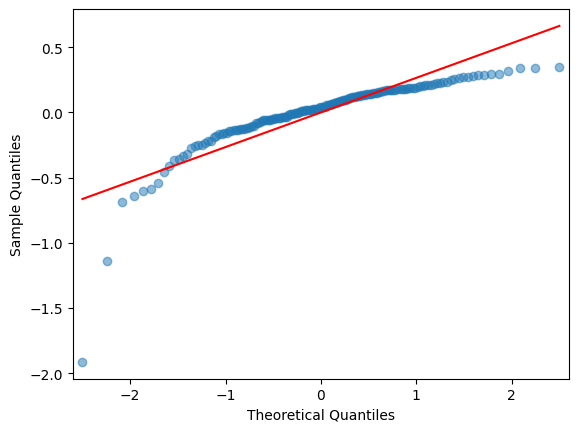

In [107]:
#QQ-plot - model 6
sm.qqplot(model_6.resid, line = 's', alpha = .5)
plt.show()

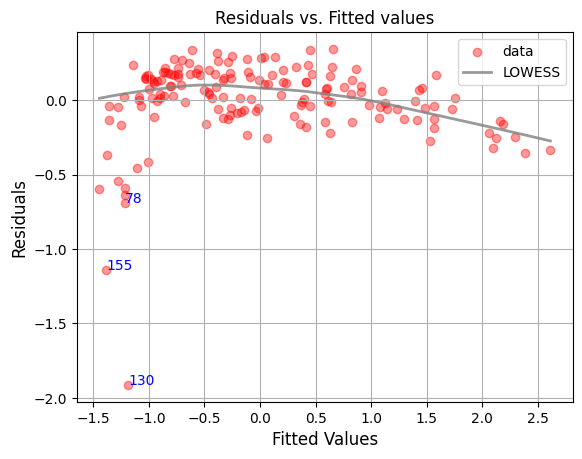

In [108]:
#Scatter plot of residuals vs. fitted values - model 6
residuals_fittedvalues_plot(model_6)

In [109]:
#Check multicollinearity for numeric variables
calc_vif(x_train)
#Note: If VIF > 10 then multicollinearity is high

,variables,VIF
0,const,14.303600
1,tv,3.701074
2,radio,3.866275
3,int_var,6.620265


In [110]:
#Check Cook's ditance - model 6
influencer_detector(model_6)

(array([], dtype=int64),)

In [111]:
#Linear regression - model 7
model_7 = sm.OLS(y_train, x_train).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1369.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          8.49e-112
Time:                        05:26:07   Log-Likelihood:                -223.30
No. Observations:                 160   AIC:                             454.6
Df Residuals:                     156   BIC:                             466.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8590      0.296     23.186      0.000       6.275       7.443
tv             0.0186      0.002     10.559      0.000       0.015       0.022
radio          0.0263      0.010      2.549      0.012       0.006       0.047
int_var        0.0011   6.08e-05     18.005      0.000       0.001       0.001
==============================================================================
Omnibus:                      114.737   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.905
Skew:                          -2.538   Prob(JB):                    3.17e-235
Kurtosis:                      14.672   Cond. No.                     1.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

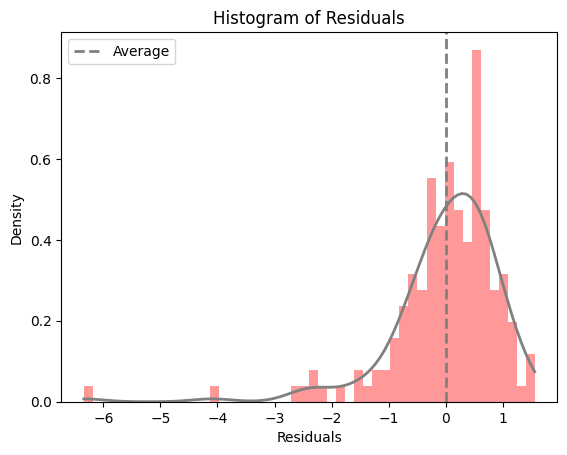

In [112]:
#Histogram of residuals model 7
hist_residuals(model_7)

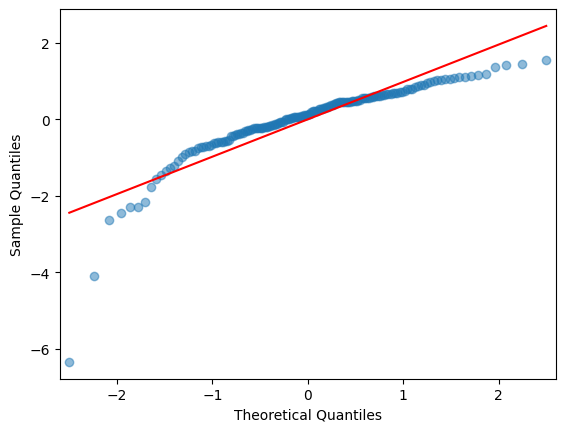

In [113]:
#QQ-plot - model 7
sm.qqplot(model_7.resid, line = 's', alpha = .5)
plt.show()

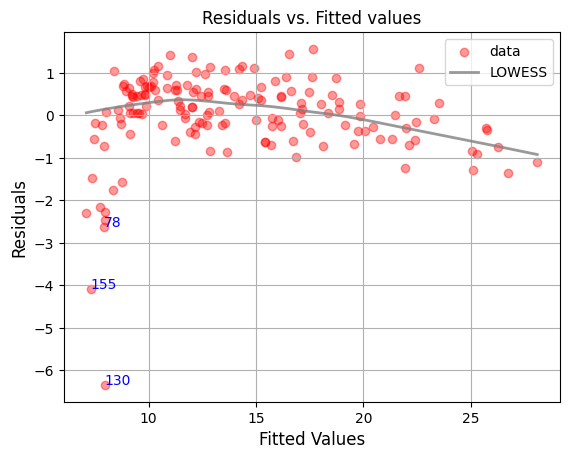

In [114]:
#Scatter plot of residuals vs. fitted values - model 7
residuals_fittedvalues_plot(model_7)

In [116]:
#Check Cook's ditance - model 7
influencer_detector(model_7)

(array([], dtype=int64),)

In [117]:
#Remove non-significant variables from regression model
x_train.drop(columns = ['radio'], inplace = True)

In [118]:
#Check multicollinearity for numeric variables
calc_vif(x_train)
#Note: If VIF > 10 then multicollinearity is high

,variables,VIF
0,const,4.105021
1,tv,1.712467
2,int_var,1.712467


In [128]:
#Linear regression - model 8
model_8 = sm.OLS(trans_y_train, x_train).fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     983.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.64e-89
Time:                        05:34:05   Log-Likelihood:                -18.685
No. Observations:                 160   AIC:                             43.37
Df Residuals:                     157   BIC:                             52.60
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3145      0.044    -29.894      0.000      -1.401      -1.228
tv             0.0035      0.000     10.687      0.000       0.003       0.004
int_var        0.0002   8.57e-06     25.990      0.000       0.000       0.000
==============================================================================
Omnibus:                      122.662   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1327.616
Skew:                          -2.721   Prob(JB):                    5.15e-289
Kurtosis:                      16.020   Cond. No.                     9.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

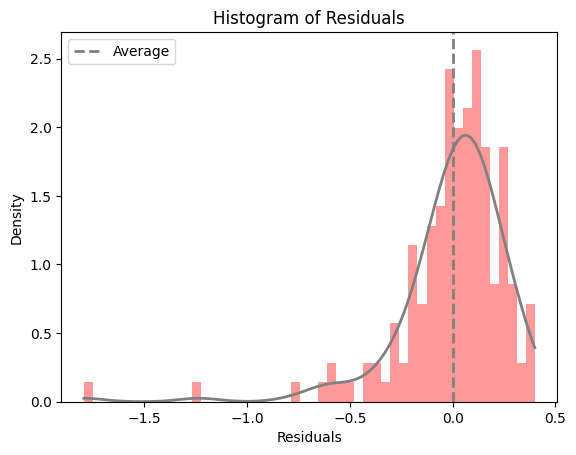

In [129]:
#Histogram of residuals model 8
hist_residuals(model_8)

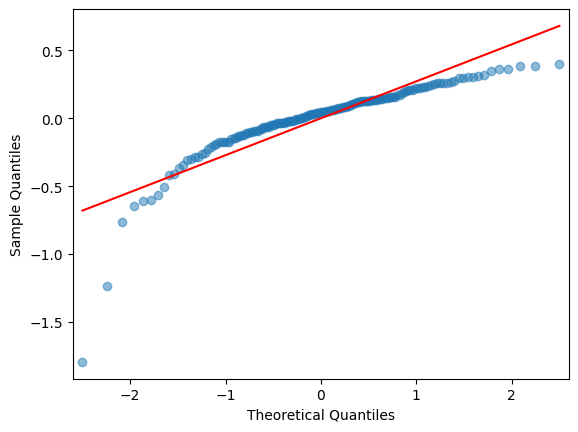

In [130]:
#QQ-plot - model 8
sm.qqplot(model_8.resid, line = 's', alpha = .5)
plt.show()

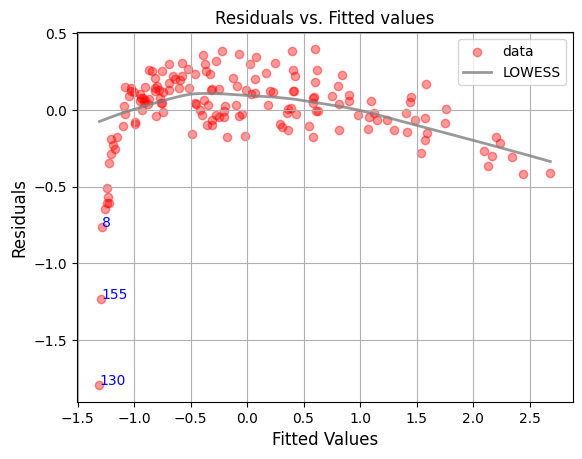

In [131]:
#Scatter plot of residuals vs. fitted values - model 8
residuals_fittedvalues_plot(model_8)

## Model Evaluation 

In [132]:
#Define the test matrix 
test['int_var'] = test['tv']*test['radio']
test.reindex(columns = ['tv', 'radio', 'newspaper', 'int_var', 'sales'])
x_test = test.loc[:, ['tv', 'int_var']]
x_test = sm.add_constant(x_test)
y_test = test['sales']

In [133]:
x_test.head()

,const,tv,int_var
50,1.0,199.8,619.38
127,1.0,80.2,0.00
37,1.0,74.7,3690.18
149,1.0,44.7,1153.26
19,1.0,147.3,3520.47


In [134]:
y_test.head()

50     11.4
127     8.8
37     14.7
149    10.1
19     14.6
Name: sales, dtype: float64

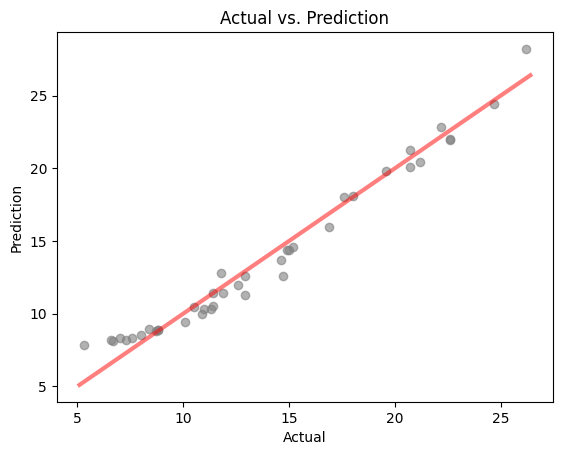

In [135]:
#Plot actual vs. prediction - Test
test_pred = model_8.predict(x_test)


#Inverse transformation of predicted values
test['pred_sale'] = pd.Series(boxcox.inverse_transform(test_pred.values.reshape(-1, 1)).reshape(-1), 
                         index = test_pred.index)

plt.scatter(test['sales'], test['pred_sale'], c = 'gray', alpha = .6)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction')
xp = np.linspace(test['sales'].min() - 0.2, test['sales'].max() + 0.2, 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .5)
plt.show()

In [136]:
#Absolute error
test['abs_err'] = round(abs(test['sales'] - test['pred_sale']) / test['sales'] , 2)
MAE_test = round(np.mean(test['abs_err']), 2)
MAE_test

0.07

In [137]:
#Absolute percentage error
test['abs_pct_err'] = round(abs(test['sales'] - test['pred_sale']) / test['sales'] * 100, 2)
MAPE_test = round(np.mean(test['abs_pct_err']), 2)
MAPE_test

7.2

In [138]:
#Check obervations with large absolute percentage error
test.sort_values(by = 'abs_pct_err', ascending = False, inplace = True)
test.head()

,no,tv,radio,newspaper,sales,int_var,pred_sale,abs_err,abs_pct_err
108,109,13.1,0.4,25.6,5.3,5.24,7.827719,0.48,47.69
119,120,19.4,16.0,22.3,6.6,310.40,8.211832,0.24,24.42
189,190,18.7,12.1,23.4,6.7,226.27,8.120993,0.21,21.21
121,122,18.8,21.7,50.4,7.0,407.96,8.296068,0.19,18.52
37,38,74.7,49.4,45.7,14.7,3690.18,12.613507,0.14,14.19


In [139]:
#Marketing Requirement
sum(test['abs_pct_err'] <= 15) / test.shape[0] * 100

90.0